# Setup
To run DeepChem in Colab, we'll first need to run the following lines of code, these will download conda in the colab environment.

In [47]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  33342      0 --:--:-- --:--:-- --:--:-- 33342


python version: 3.7.10
remove current miniconda
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [48]:
#!pip install dgllife
#!pip install dgl
#import dgllife

In [49]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

'2.6.0.dev'

In [39]:
import model_v1

In [40]:
import rdkit

In [41]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [42]:
model_v1.featurizer

<function model_v1.featurizer(mol, max_length=10)>

# Graphic Generative Model

## Preparations

Now we are ready to import some useful packages.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
import deepchem as dc 

Here we'll import our dataset for training. 

This dataset contains  In-vitro assay that detects inhibition of SARS-CoV 3CL protease via fluorescence from PubChem AID1706

In [45]:
df = pd.read_csv('AID1706_binarized_sars.csv')

In [46]:
df.head()

,smiles,activity
0,CC1=CC=C(O1)C(C(=O)NCC2=CC=CO2)N(C3=CC=C(C=C3)...,1
1,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)S(=O)(=O)C3=C...,1
2,CC1=CC2=C(C=C1)NC(=O)C(=C2)CN(CCC3=CC=CC=C3)CC...,1
3,CC1=CC=C(C=C1)CN(C(C2=CC=CS2)C(=O)NCC3=CC=CO3)...,1
4,CCN1C2=NC(=O)N(C(=O)C2=NC(=N1)C3=CC=CC=C3)C,1


In [47]:
df.groupby('activity').count()

,smiles
activity,
0,290321
1,405


Observe the data above, it contains a 'smiles' column, which stands for the smiles representation of the molecules. There is also an 'activity' column, in which it is the label specifying whether that molecule is considered as hit for the protein.

### Select subpart for testing

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
from sklearn.utils import resample
true = df[df['activity']==1]
false = df[df['activity']==0]

In [50]:
false_short = resample(false, n_samples=2000, replace = False)
ihbt = pd.concat([false_short , true], ignore_index =  True)

We'll now select atoms of a fix length. Since we'll be using graphic neural network, some compensate for that is that we might loss some data.

In [51]:
input_df = ihbt['smiles']
df_length = []
for _ in input_df:
    df_length.append(Chem.MolFromSmiles(_).GetNumAtoms() )

In [52]:
ihbt['length'] = df_length #create a new column containing each molecule's length

In [53]:
ihbt = ihbt[ihbt['length']>10] #Here we leave only the ones longer than 10
input_df = ihbt['smiles']
input_df1 = input_df.apply(Chem.MolFromSmiles) 


In [54]:
bond_types = [
          Chem.rdchem.BondType.ZERO,
          Chem.rdchem.BondType.SINGLE,
          Chem.rdchem.BondType.DOUBLE,
          Chem.rdchem.BondType.TRIPLE,
          Chem.rdchem.BondType.AROMATIC,
        ]
encoder = {j:i for i, j in enumerate(bond_types,1)}

In [55]:
#input_df = input_df.apply(Chem.MolFromSmiles) 
input_df = input_df1.apply(model_v1.featurizer(11))

NameError: name 'rdkit' is not defined

In [31]:
#X_train, X_test, y_train, y_test = train_test_split(input_df, ihbt['activity'], test_size = 0.3)

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Real Train Test Split

Since we'll be using multiple inputs, we'll create a tensorflow dataset to handle that for us.

In [67]:
x_train, x_test, y_train, y_test = train_test_split(input_df, ihbt['activity'], test_size = 0.2 )

In [68]:
nodes_train, edges_train = list(zip(*x_train) )
nodes_test, edges_test = list(zip(*x_test))


In [69]:
nd_train = np.array(nodes_train)
eg_train = np.array(edges_train)

In [70]:
nd_test = np.array(nodes_test)
eg_test = np.array(edges_test)

-----------------------------

### Train test splits finally!

---------------------

## Discriminator

Now we are finally ready to build a discriminator of our GAN Model. Discriminator has the same logics as a common classification model.

In [71]:
def make_discriminator(num_atoms):
  '''
  create a discriminator model that takes in two inputs: nodes and edges of a single molecule
  graphic neural network
  '''
  # This is the one!

  #conv_node = layers.Conv2D(
      #32, (3, 3), activation='relu', input_shape=(10, None)
  #)
  conv_edge = layers.Conv1D(32, (3,), activation = 'relu', input_shape = (num_atoms,num_atoms))
  edges_tensor = keras.Input(shape = (num_atoms,num_atoms), name = 'edges')
  x_edge = conv_edge(edges_tensor)
  #x_edge = layers.MaxPooling1D((2,))(x_edge)
  x_edge = layers.Conv1D(64, (3,), activation='relu')(x_edge)
  x_edge = layers.Flatten()(x_edge)
  x_edge = layers.Dense(64, activation = 'relu')(x_edge)

  nodes_tensor = keras.Input(shape = (num_atoms,), name = 'nodes' )
  x_node = layers.Dense(32, activation = 'relu' )(nodes_tensor)
  x_node = layers.Dropout(0.2)(x_node)
  x_node = layers.Dense(64, activation = 'relu')(nodes_tensor)

  main = layers.concatenate([x_node,x_edge], axis = 1)
  main = layers.Dense(32, activation='relu')(main)
  output = layers.Dense(1, activation = 'sigmoid', name = 'label')(main)# number of classes

  return keras.Model(
    inputs = [nodes_tensor, edges_tensor],
    outputs = output
    )

In [72]:
discriminator = make_discriminator(11)

### Set the weight for training

In [73]:
hit_count, nonhit_count = np.bincount(ihbt['activity'])
total_count = len(ihbt['activity'])
weight_nonhit = (1 / nonhit_count) * (total_count) / 2.0
weight_hit = (1 / hit_count) * (total_count) / 2.0
class_weights = {0: weight_nonhit, 1: weight_hit}
#Now, let’s use the weights when training our model:

#model = build_model(X_train, metrics=METRICS)


In [74]:
discriminator.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = discriminator.fit([nd_train, eg_train],
                    y_train,
                    epochs=80, 
                    verbose = False,
                    class_weight=class_weights
                    #steps_per_epoch = 100,
                    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


[Text(0, 0.5, 'training accuracy'), Text(0.5, 0, 'epoch')]

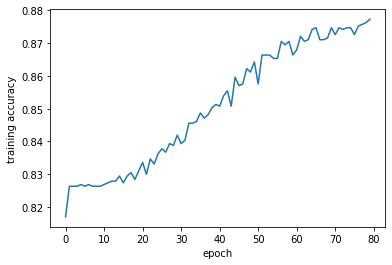

In [75]:
 plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

In [76]:
discriminator.evaluate([nd_test, eg_test], y_test, verbose = 2)

16/16 - 0s - loss: 0.7723 - accuracy: 0.8378


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


[0.7722929120063782, 0.837837815284729]

In [77]:
def get_discriminator_loss(real_predictions,fake_predictions):
    real_predictions = tf.sigmoid(real_predictions)#predictions of the real images
    fake_predictions = tf.sigmoid(fake_predictions)#prediction of the images from the generator
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_predictions),real_predictions)# as such
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_predictions),fake_predictions)
    return real_loss+ fake_loss

In [78]:
nd_test.shape

(481, 11)

## Generator

In [79]:
BATCH_SIZE = len(nd_train)

In [80]:
def make_generator(num_atoms, noise_input_shape):
  '''create generator model
  '''
  inputs = keras.Input(shape = (noise_input_shape,))
  x = layers.Dense(128, activation="tanh")(inputs)# input_shape = (noise_input_shape,) )#256: filters
  #x = layers.Dropout(0.2)(x)
  x = layers.Dense(256,activation="tanh")(x)
  #x = layers.Dropout(0.2)(x)
  x = layers.Dense(528,activation="tanh")(x)

  #generating edges
  edges_gen = layers.Dense(units =num_atoms*num_atoms)(x)
  edges_gen = layers.Reshape((num_atoms, num_atoms ))(edges_gen)

  nodes_gen = layers.Dense(units = num_atoms)(x)
  #assert nodes_gen.output_shape == (num_atoms)
  #nodes_gen = layers.Reshape(num_atoms, num_atoms)(edges_gen)

  #y = zeros(())
  return keras.Model(
    inputs = inputs,
    outputs = [nodes_gen, edges_gen]
    )

  #return [nodes_gen, edges_gen]


In [81]:
generator = make_generator(11, 100)

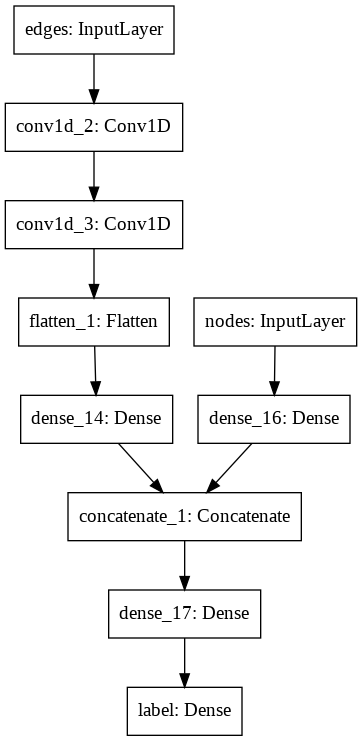

In [82]:
keras.utils.plot_model(discriminator)

In [83]:
discriminator.predict(generator.predict(np.random.randint(0,2, size =(1,100))))

array([[0.09650186]], dtype=float32)

In [84]:
def get_generator_loss(fake_predictions):
  fake_predictions = tf.sigmoid(fake_predictions)#prediction of the images from the generator
  fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
  return fake_loss

## GAN

In [85]:
#discriminator = make_discriminator(11)
generator = make_generator(11, 100)

In [86]:
def train_step(mol,old_gen_loss,old_disc_loss):
  fake_mol_noise = np.random.randn(batch_size, 100)# input for the generator
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    real_output = discriminator.evaluate(mol[:2])# trainable = False)

    generated_mols = generator(fake_mol_noise)
    fake_output = discriminator(generated_mols)

    gen_loss = get_generator_loss(fake_output)
    disc_loss = get_discriminator_loss(real_output, fake_output)

        #optimizers would improve the performance of the model with these gradients
    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc= disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer = tf.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.optimizers.Adam(1e-4)
    generator_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))

    print('generator loss: ', np.mean(gen_loss))
    print('discriminator loss', np.mean(disc_loss))

In [87]:
def train(nodes,edges, epochs):
  for _ in range(epochs):
    gen_loss = 0
    disc_loss = 0
    for n,e in zip(nodes, edges):
      train = [n.reshape(1,11),e.reshape(1,11,11)]
      train_step(train,gen_loss,disc_loss)
    display.clear_output(wait=True)
    #if (epoch+1)

In [88]:

batch_size = 20
train(nd_train,eg_train, 2)

generator loss:  0.6931469
discriminator loss 1.3862938
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
generator loss:  0.6931469
discriminator loss 1.3862938
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
generator loss:  0.6931469
discriminator loss 1.3862938
1/1 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
generator loss:  0.6931469
discriminator loss 1.3862938
1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
generator loss:  0.6931469
discriminator loss 1.3862938
1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
generator loss:  0.6931469
discriminator loss 1.3862938
1/1 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
generator loss:  0.6931469
discriminator loss 1.3862938
1/1 [==============================] - 0s 19

KeyboardInterrupt: ignored

In [ ]:
#batch_size = 20
#train(x_train , 30)

In [175]:
no, ed = generator(np.random.randint(0,2, size =(1,100)))

In [ ]:
discriminator(generator(np.random.randint(0,2, size =(1,100))))

In [204]:
cat = de_featurizer(abs(no.numpy()*10).astype(int).reshape(11), abs(ed.numpy()*10).astype(int).reshape(11,11))

In [207]:
cat

In [205]:
Chem.MolToSmiles(cat)

'[Li]123~b45678~B9%10%11%12%13~[H]4%14%15%16~[h]5=194%17%18~[li]=6159c=46%19(~B#%14=%10=%1724=[H]#%11=7316#c%18#%19#%12=%15=5=4)[H]=9=8%16%13'

In [206]:
abs(no.numpy()*10).astype(int).reshape(11), abs(ed.numpy()*10).astype(int).reshape(11,11)

(array([5, 1, 1, 6, 1, 1, 3, 6, 3, 5, 5]),
 array([[1, 1, 2, 4, 2, 4, 0, 0, 0, 1, 3],
        [3, 3, 1, 3, 2, 0, 8, 6, 7, 2, 4],
        [1, 1, 0, 5, 0, 0, 3, 3, 1, 5, 3],
        [1, 0, 1, 2, 9, 4, 0, 4, 3, 0, 3],
        [0, 2, 2, 7, 2, 8, 0, 2, 3, 3, 0],
        [0, 1, 0, 3, 5, 3, 2, 2, 2, 3, 3],
        [3, 2, 4, 0, 0, 4, 3, 0, 0, 1, 2],
        [2, 5, 4, 0, 3, 2, 4, 0, 5, 0, 1],
        [0, 1, 5, 5, 0, 2, 1, 4, 3, 3, 0],
        [4, 4, 6, 3, 0, 6, 7, 2, 7, 1, 0],
        [4, 0, 4, 5, 9, 2, 4, 7, 3, 7, 0]]))